In [1]:
import os

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [5]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples[:, ::-1, :], targets

In [6]:
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback, 
    delay=delay, 
    min_index=0, 
    max_index=200000, 
    shuffle=True, 
    step=step, 
    batch_size=batch_size
)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback, 
    delay=delay, 
    min_index=200001, 
    max_index=300000, 
    shuffle=True, 
    step=step, 
    batch_size=batch_size
)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen_reverse, 
                    steps_per_epoch=500, 
                    epochs=20, 
                    validation_data=val_gen_reverse, 
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 47s 92ms/step - loss: 0.4866 - val_loss: 0.4839
Epoch 2/20
500/500 [==============================] - 46s 92ms/step - loss: 0.4358 - val_loss: 0.4407
Epoch 3/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3836 - val_loss: 0.4062
Epoch 4/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3433 - val_loss: 0.3827
Epoch 5/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3241 - val_loss: 0.3805
Epoch 6/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3114 - val_loss: 0.3794
Epoch 7/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2997 - val_loss: 0.3644
Epoch 8/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2852 - val_loss: 0.3667
Epoch 9/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2765 - val_loss: 0.3478
Epoch 10/20
500/500 [==============================] - 46s 92ms/step - loss: 0.269

In [8]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

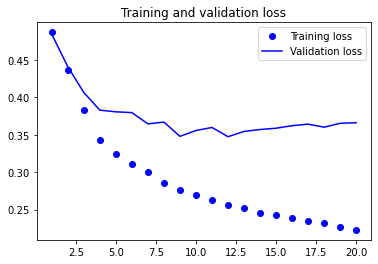

In [9]:
plot_loss(history)

In [10]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [11]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 38s 237ms/step - loss: 0.5059 - acc: 0.7577 - val_loss: 0.3429 - val_acc: 0.8700
Epoch 2/10
157/157 [==============================] - 37s 235ms/step - loss: 0.3193 - acc: 0.8760 - val_loss: 0.3303 - val_acc: 0.8648
Epoch 3/10
157/157 [==============================] - 37s 235ms/step - loss: 0.2511 - acc: 0.9070 - val_loss: 0.4532 - val_acc: 0.8156
Epoch 4/10
157/157 [==============================] - 37s 234ms/step - loss: 0.2142 - acc: 0.9240 - val_loss: 0.3194 - val_acc: 0.8732
Epoch 5/10
157/157 [==============================] - 37s 234ms/step - loss: 0.1977 - acc: 0.9299 - val_loss: 0.3482 - val_acc: 0.8808
Epoch 6/10
157/157 [==============================] - 37s 233ms/step - loss: 0.1669 - acc: 0.9427 - val_loss: 0.3665 - val_acc: 0.8598
Epoch 7/10
157/157 [==============================] - 37s 234ms/step - loss: 0.1454 - acc: 0.9501 - val_loss: 0.4072 - val_acc: 0.8722
Epoch 8/10
157/157 [==============================] - 3